In [5]:
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Flatten, Dense, Dropout, Lambda
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import backend as K
import pandas
import numpy as np
import pickle as pk
import sklearn as sk

2023-05-27 01:25:15.349757: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-05-27 01:25:15.935788: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [6]:
data = pandas.read_csv("./../codes/semantic.csv")
data.dropna()
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
  try:
    # Currently, memory growth needs to be the same across GPUs
    for gpu in gpus:
      tf.config.experimental.set_memory_growth(gpu, True)
    logical_gpus = tf.config.experimental.list_logical_devices('GPU')
    print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
  except RuntimeError as e:
    # Memory growth must be set before GPUs have been initialized
    print(e)



2023-05-27 01:25:19.583125: E tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:266] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected


In [7]:
x = data.iloc[0:, 0:32].values.astype("float64")
y = data.iloc[0:, 32].values.astype("bool")

In [15]:
tf.random.set_seed(120)
tf.keras.backend.clear_session()
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.3, random_state=23)
x_train_0 = np.array([x[0:16] for x in x_train])
x_train_1 = np.array([x[16:32] for x in x_train])
x_test_0 = np.array([x[0:16] for x in x_test])
x_test_1 = np.array([x[16:32] for x in x_test])

print(x_train_0.shape)
from tensorflow.keras.regularizers import l2
from tensorflow.keras.layers import Concatenate
from tensorflow.keras import layers, Model, backend as K

def create_base_network(input_shape):
    input = layers.Input(shape=(input_shape,))
    x = layers.Dense(128, activation='relu')(input)
    x = layers.Dense(64, activation='relu')(x)
    x = layers.Dense(64, activation='relu')(x)
    return Model(input, x)

def euclidean_distance(vects):
    x, y = vects
    sum_square = K.sum(K.square(x - y), axis=1, keepdims=True)
    return K.sqrt(K.maximum(sum_square, K.epsilon()))

def create_siamese_network(input_shape):
    # Define the tensors for the two input images
    input_1 = layers.Input(shape=(input_shape,))
    input_2 = layers.Input(shape=(input_shape,))

    # Create the base network
    base_network = create_base_network(input_shape)

    # Use the base network to process the inputs
    processed_1 = base_network(input_1)
    processed_2 = base_network(input_2)

    # Compute the Euclidean distance between the two vector outputs
    dist = layers.Lambda(euclidean_distance)([processed_1, processed_2])

    # Add a dense layer with a sigmoid unit to generate the similarity score
    outputs = layers.Dense(1, activation='sigmoid')(dist)

    # Instantiate the model
    siamese_net = Model([input_1, input_2], outputs)
    
    return siamese_net

model = create_siamese_network(16)
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

(210140, 16)


In [16]:
history = model.fit([x_train_0,x_train_1], y_train,validation_data=([x_test_0,x_test_1],y_test), epochs=60)

Epoch 1/60
6567/6567 [==============================] - 8s 1ms/step - loss: 0.6381 - accuracy: 0.6279 - val_loss: 0.6264 - val_accuracy: 0.6459
Epoch 2/60
6567/6567 [==============================] - 7s 1ms/step - loss: 0.6263 - accuracy: 0.6417 - val_loss: 0.6307 - val_accuracy: 0.6343
Epoch 3/60
6567/6567 [==============================] - 7s 1ms/step - loss: 0.6213 - accuracy: 0.6489 - val_loss: 0.6188 - val_accuracy: 0.6506
Epoch 4/60
6567/6567 [==============================] - 7s 1ms/step - loss: 0.6147 - accuracy: 0.6552 - val_loss: 0.6148 - val_accuracy: 0.6571
Epoch 5/60
6567/6567 [==============================] - 6s 962us/step - loss: 0.6108 - accuracy: 0.6606 - val_loss: 0.6064 - val_accuracy: 0.6711
Epoch 6/60
6567/6567 [==============================] - 6s 859us/step - loss: 0.6048 - accuracy: 0.6676 - val_loss: 0.6048 - val_accuracy: 0.6722
Epoch 7/60
6567/6567 [==============================] - 6s 867us/step - loss: 0.5959 - accuracy: 0.6767 - val_loss: 0.5873 - val_acc

6567/6567 [==============================] - 8s 1ms/step - loss: 0.0472 - accuracy: 0.9839 - val_loss: 0.0334 - val_accuracy: 0.9899
Epoch 58/60
6567/6567 [==============================] - 8s 1ms/step - loss: 0.0439 - accuracy: 0.9850 - val_loss: 0.0432 - val_accuracy: 0.9850
Epoch 59/60
6567/6567 [==============================] - 7s 1ms/step - loss: 0.0417 - accuracy: 0.9862 - val_loss: 0.0506 - val_accuracy: 0.9838
Epoch 60/60
6567/6567 [==============================] - 8s 1ms/step - loss: 0.0387 - accuracy: 0.9871 - val_loss: 0.0190 - val_accuracy: 0.9950


In [17]:

y_pred = model.evaluate([x_test_0,x_test_1],y_test)


2815/2815 [==============================] - 1s 522us/step - loss: 0.0190 - accuracy: 0.9950


2815/2815 [==============================] - 1s 437us/step
              precision    recall  f1-score   support

       False       1.00      0.99      0.99     44922
        True       0.99      1.00      0.99     45138

    accuracy                           0.99     90060
   macro avg       0.99      0.99      0.99     90060
weighted avg       0.99      0.99      0.99     90060

AUC-ROC: 0.9998115357160184


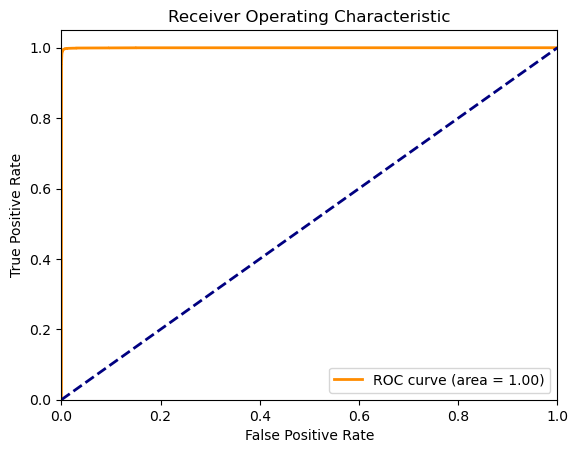

In [18]:
from sklearn.metrics import classification_report, roc_auc_score, roc_curve, auc
import matplotlib.pyplot as plt

# Assuming that 'model' is your trained model and 'X_test', 'y_test' are your test data.

# Predict the probabilities for the test data
y_pred_prob = model.predict([x_test_0,x_test_1]).ravel()

# Predict the classes for the test data
y_pred = np.round(y_pred_prob)

# Print precision, recall, and F1-score
print(classification_report(y_test, y_pred))

# Calculate AUC-ROC
roc_auc = roc_auc_score(y_test, y_pred_prob)
print("AUC-ROC:", roc_auc)

# Calculate ROC curve
fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)

# Plot ROC curve
plt.figure()
lw = 2  # Line width
plt.plot(fpr, tpr, color='darkorange', lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

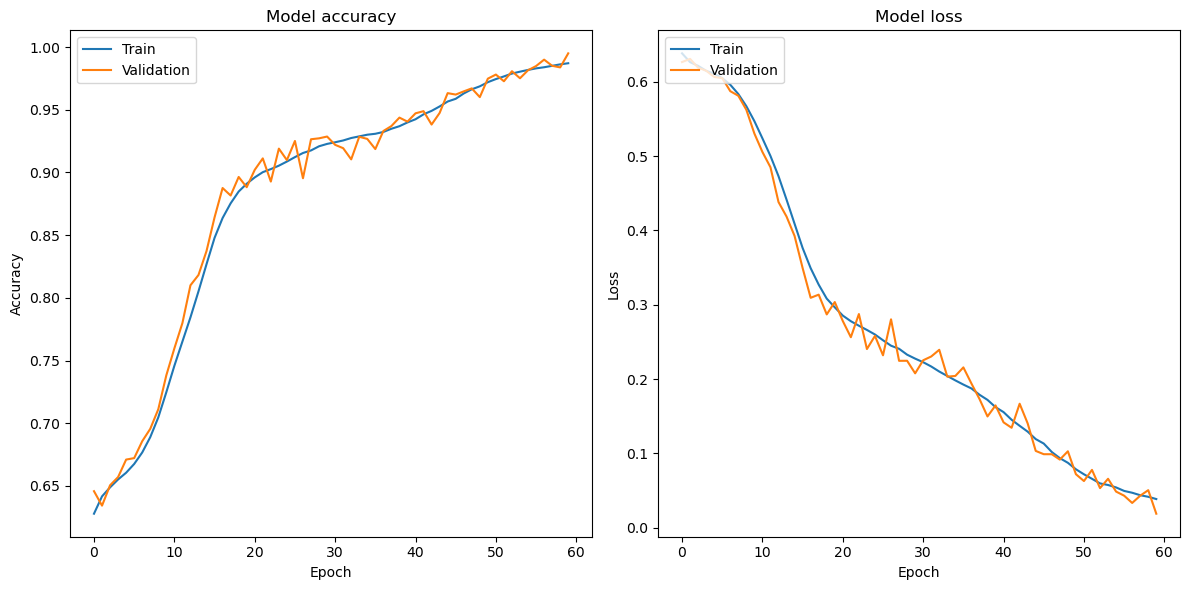

In [19]:
import matplotlib.pyplot as plt

# Assuming that 'model' is your trained model, and 'history' is the returned History object from model.fit
# e.g., history = model.fit(x_train, y_train, validation_data=(x_val, y_val), epochs=20)

# Plot training & validation accuracy values
plt.figure(figsize=(12,6))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.tight_layout()
plt.show()

In [21]:
history.history


{'loss': [0.6381441950798035,
  0.6262973546981812,
  0.6213011145591736,
  0.6146948933601379,
  0.6107722520828247,
  0.6047720313072205,
  0.5959269404411316,
  0.583428144454956,
  0.5670763850212097,
  0.5469594597816467,
  0.5238144993782043,
  0.500100314617157,
  0.47295066714286804,
  0.4414101839065552,
  0.40887948870658875,
  0.37638840079307556,
  0.349214106798172,
  0.3270570635795593,
  0.30824410915374756,
  0.296542227268219,
  0.28542548418045044,
  0.2778681516647339,
  0.2718068063259125,
  0.2661340832710266,
  0.26000985503196716,
  0.25225377082824707,
  0.24492190778255463,
  0.24077941477298737,
  0.23286226391792297,
  0.22754205763339996,
  0.22272339463233948,
  0.21696743369102478,
  0.21016542613506317,
  0.20421873033046722,
  0.19825705885887146,
  0.19264696538448334,
  0.18743623793125153,
  0.17900751531124115,
  0.17207403481006622,
  0.16228634119033813,
  0.1555940806865692,
  0.14530788362026215,
  0.13720910251140594,
  0.12931989133358002,
  0.

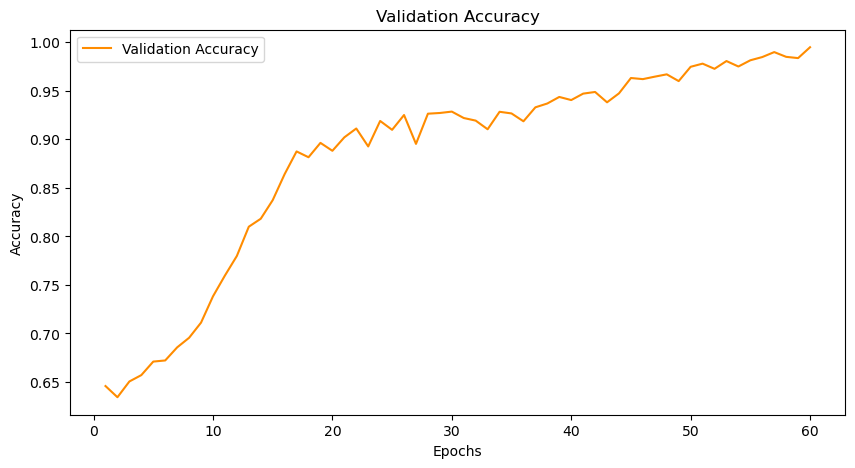

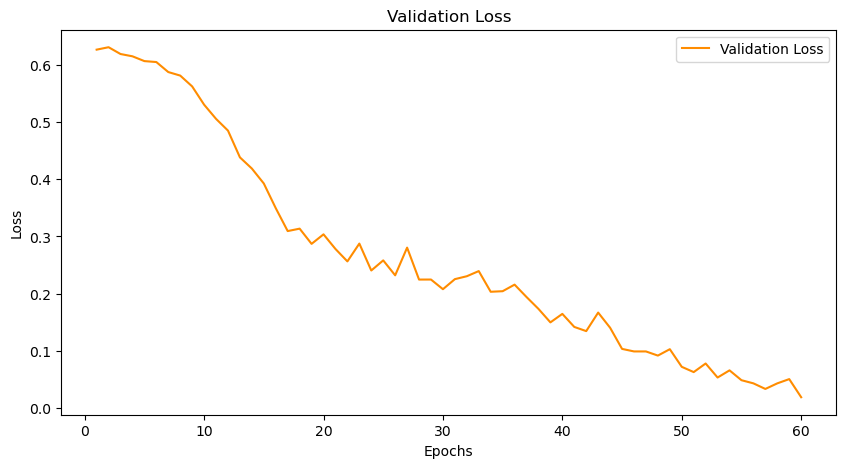

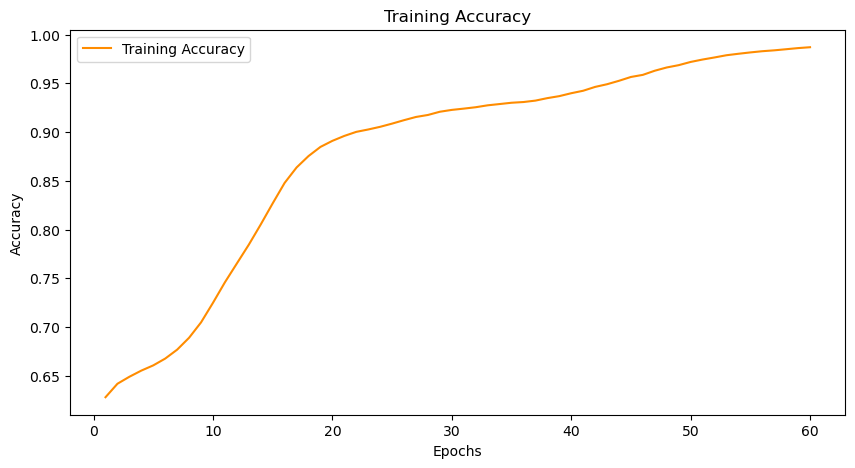

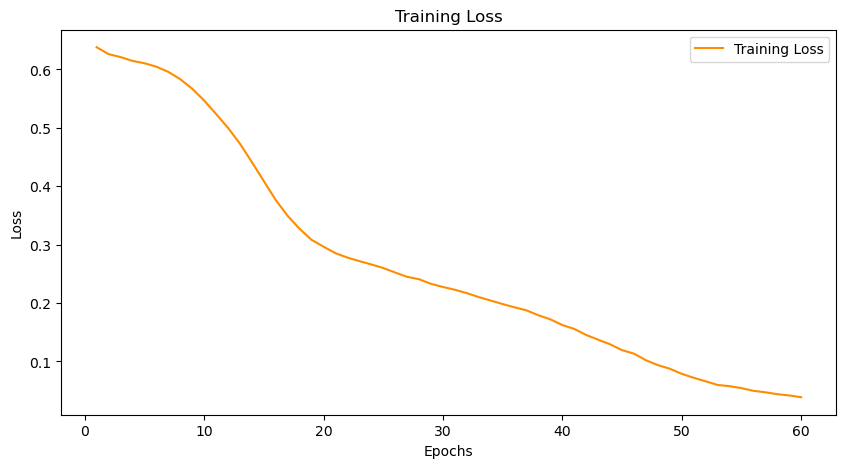

In [22]:
import matplotlib.pyplot as plt

# Extracting metrics from the history object
validation_accuracy = history.history['val_accuracy']
validation_loss = history.history['val_loss']
training_accuracy = history.history['accuracy']
training_loss = history.history['loss']

# Getting the number of epochs
num_epochs = len(validation_accuracy)

# Plotting validation accuracy
plt.figure(figsize=(10, 5))
plt.plot(range(1, num_epochs + 1), validation_accuracy, label='Validation Accuracy', color="darkorange")
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Validation Accuracy')
plt.legend()
plt.show()

# Plotting validation loss
plt.figure(figsize=(10, 5))
plt.plot(range(1, num_epochs + 1), validation_loss, label='Validation Loss', color="darkorange")
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Validation Loss')
plt.legend()
plt.show()

# Plotting training accuracy
plt.figure(figsize=(10, 5))
plt.plot(range(1, num_epochs + 1), training_accuracy, label='Training Accuracy', color="darkorange")
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training Accuracy')
plt.legend()
plt.show()

# Plotting training loss
plt.figure(figsize=(10, 5))
plt.plot(range(1, num_epochs + 1), training_loss, label='Training Loss', color="darkorange")
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training Loss')
plt.legend()
plt.show()
